### ABSTRACT
- Background: Food insecurity affects 2.3 billion people globally, with smallholder farming households disproportionately affected. 

- Machine learning approaches offer potential for scalable identification of food insecure households to guide targeted interventions.

- Objective: To develop and evaluate machine learning models for binary food security classification using comprehensive household indicators from the RHoMIS dataset across 21 developing countries.

- Methods: This study analyzed 13,310 farm households (2015-2018) using four classification algorithms: 
    - Random Forest 
    - XGBoost
    - LightGBM 
    - Logistic Regression. 
    
- The target variable distinguished food secure from food insecure households. Models were evaluated using stratified cross-validation with metrics including accuracy, F1-scores, and ROC-AUC on a test set of 2,662 households.

## METHODOLOGY
### Data Preparation and Preprocessing

1. Description: The RHoMIS dataset covers 13,310 farm households across 21 countries and was collected from 2015 to 2018
Feature Selection: We were able to Reduce the original features to 26 relevant variables after removing ID columns, and redundant indicators

2. Missing Data Handling:

    We noted that there were no rows within target variable (HFIAS_status), that had null values 
    
    We then applied median imputation for numerical features and used the most frequent value imputation for categorical features


3. Feature Engineering:
    
- Label encoding for categorical variables. The categorical values included:
        
    - HFIAS_status (The target variable) - Assigned the values [0, 1, 2, 3, 4] to the different categories

    - Country - Assigned values within the range [0, 20] as there were 21 countries
    
- StandardScaler for numerical features to handle different scales (income vs. household size)

4. Data Splitting: 80/20 train-test split with stratification to maintain class distribution

5. Machine Learning Pipeline

- Cross-Validation Strategy: 
    - 5-fold Stratified Cross-Validation to ensure robust model evaluation

- Model Selection: 
    - Tested multiple algorithms suited for multi-class classification:

        - Random Forest (ensemble method, handles mixed data types)
        - Logistic Regression (interpretable baseline)
        - Gradient Boosting (sequential learning)
        - Support Vector Machine (complex decision boundaries)
        - XGBoost

6. Hyperparameter Optimization: 
    - GridSearchCV with focused parameter ranges for computational efficiency
    - Evaluation Metrics:
        - Primary: F1-macro score (equal treatment of all food security classes)
        - Secondary: Accuracy, Precision, and Recall for comprehensive assessment

In [3]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/home/jakes/Downloads/dataverse_files (3)/EDA/Data Mining/RHoMIS_Indicators.csv", encoding='latin1')

df['Altitude'] = pd.to_numeric(df['Altitude'], errors='coerce')

0    NaN
1    NaN
2    NaN
Name: Region, dtype: object

- To remain with a clean dataset, we dropped columns having more than 50% missing values as well as columns we deemed not to be as impactful in predicting the target variable

- Some of the columns we will drop include:
    - ID_PROJ 
    - ID_COUNTRY 
    - YEAR 
    - ITERATION 
    - SURVEY_ID 
    - ID_HH

- Next, we separated the target variable and the rest of the features as well as splitting the dataset into training and testing portions, where 20% of the data was used for testing and 80% used for training as shown below

In [5]:
df_cleaned = df[['Country',
'Altitude',
'HFIAS_status',
'Food_Availability_kCal_MAE_day',
'PPI_Likelihood',
'PPI_Threshold',
'score_HDDS_farmbasedBadSeason',
'HHsizemembers',
'Gender_FemaleControl',
'LandOwned',
'LivestockHoldings',
'farm_income_USD_PPP_pHH_Yr',
'value_livestock_production_USD_PPP_pHH_Yr']]

print(f"\nDataFrame shape after dropping columns: {df_cleaned.shape}")


DataFrame shape after dropping columns: (13310, 13)


- We now plot the correlation heatmap to check for any numerical features that may have correlation >= 0.85 

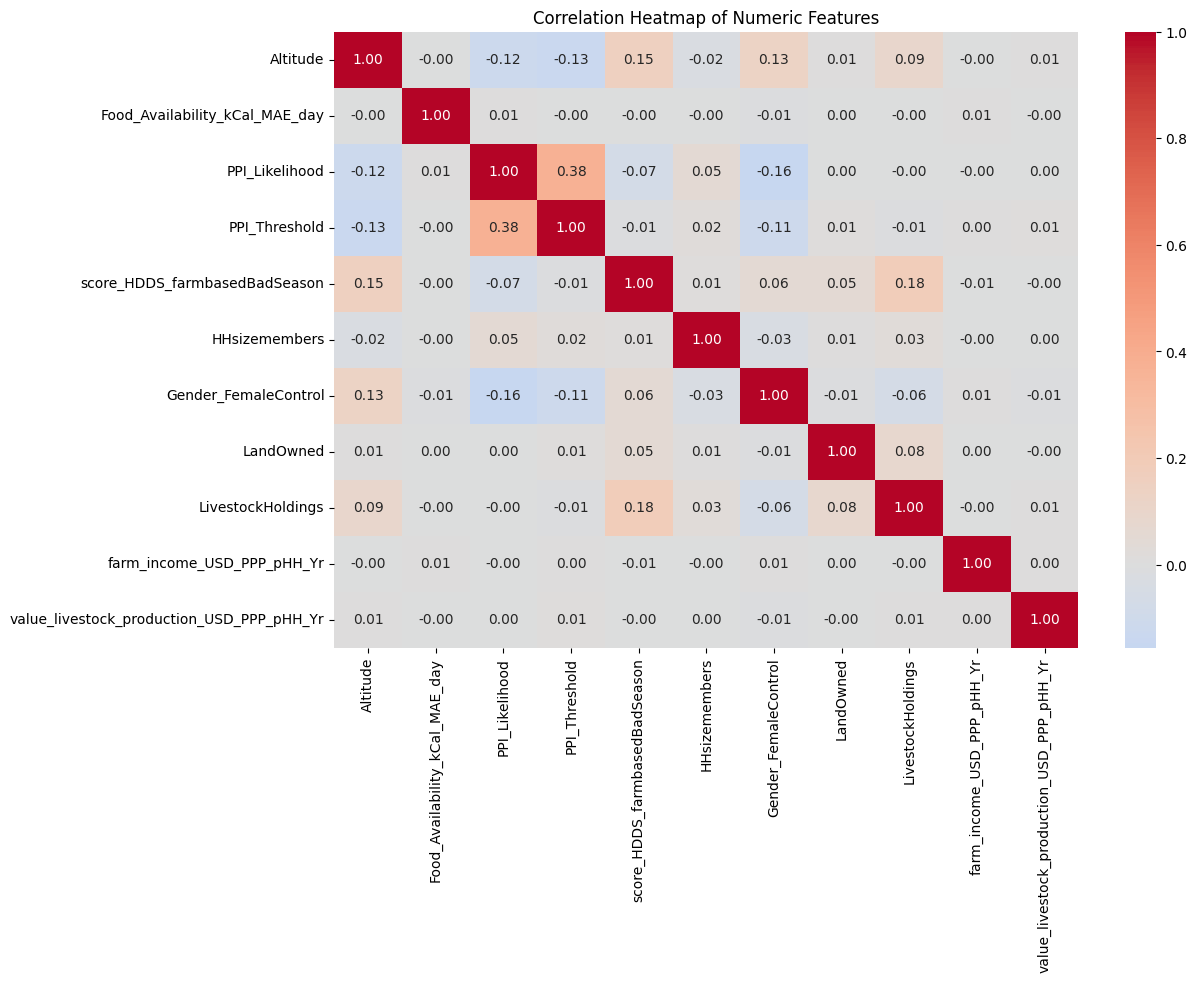

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# numeric features only
numeric_cols = df_cleaned.select_dtypes(include=['int64','float64']).columns

# correlation matrix
corr_matrix = df_cleaned[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

- Since there are no features with correlation >= 0.85, we can now proceed.

- Due to the unbalanced nature of 'HFIAS_status' categories, we can compress the four categories: FoodSecure, MildlyFI, ModeratelyFI, SeverelyFI to Secure and Insecure. This will in turn improve the performance of the model

In [7]:
df_cleaned["HFIAS_binary"] = df_cleaned["HFIAS_status"].apply(
    lambda x: "Secure" if x == "FoodSecure" else "Insecure"
)

df_cleaned['HFIAS_binary'].value_counts()

/tmp/ipykernel_86508/1514256723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["HFIAS_binary"] = df_cleaned["HFIAS_status"].apply(


HFIAS_binary
Insecure    8644
Secure      4666
Name: count, dtype: int64

In [8]:
# Separate features and target
X = df_cleaned.drop(['HFIAS_status', 'HFIAS_binary'], axis=1)
y = df_cleaned['HFIAS_binary']

# Identify feature types
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


- Splitting data followed by preprocessing 
    - Done in this order to prevent data leakage 

- Data leakage happens when information from outside the training dataset sneaks into the training process, giving the model access to data it shouldn’t have at prediction time.

In [9]:
# Splitting data and preprocessing 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (10648, 12)
Test set shape: (2662, 12)


- To handle the missing values, we opted to impute using the median values for numerical features and the most frequent for categorical features as shown below.

In [10]:
# Creating a preprocessing pipeline

# Numerical pipeline: Imputed with median, then scale
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: Imputed with most frequent, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
])


In [12]:
# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Target encodding mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} --> {i}")

Target encodding mapping:
Insecure --> 0
Secure --> 1


In [13]:
# Fit preprocessing pipeline and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nProcessed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")


Processed training set shape: (10648, 31)
Processed test set shape: (2662, 31)


- Now, we can perform modelling on the data. We use the following algorithms
    - RandomForest
    - XGBoost
    - LightGBM
    - Logistic Regression

In [15]:
# 1. RandomForest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, random_state=42
)
rf.fit(X_train_processed, y_train_encoded)

y_pred = rf.predict(X_test_processed)
y_proba = rf.predict_proba(X_test_processed)

print("Random Forest Results")
print(classification_report(y_test_encoded, y_pred))
print("ROC AUC:", roc_auc_score(y_test_encoded, y_proba[:, 1]))


Random Forest Results
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1729
           1       0.80      0.66      0.72       933

    accuracy                           0.82      2662
   macro avg       0.82      0.79      0.80      2662
weighted avg       0.82      0.82      0.82      2662

ROC AUC: 0.8789910095545567


In [16]:
# 2. XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    eval_metric="mlogloss", random_state=42
)
xgb.fit(X_train_processed, y_train_encoded)

y_pred = xgb.predict(X_test_processed)
y_proba = xgb.predict_proba(X_test_processed)

print("XGBoost Results")
print(classification_report(y_test_encoded, y_pred))
print("ROC AUC:", roc_auc_score(y_test_encoded, y_proba[:, 1]))

XGBoost Results
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1729
           1       0.78      0.67      0.72       933

    accuracy                           0.82      2662
   macro avg       0.81      0.79      0.79      2662
weighted avg       0.82      0.82      0.82      2662

ROC AUC: 0.8718063399904659


In [17]:
# 3. LightGBM

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=200, num_leaves=31, learning_rate=0.1,
    random_state=42
)
lgbm.fit(X_train_processed, y_train_encoded)

y_pred = lgbm.predict(X_test_processed)
y_proba = lgbm.predict_proba(X_test_processed)

print("LightGBM Results")
print(classification_report(y_test_encoded, y_pred))
# For binary classification, use probabilities for the positive class
print("ROC AUC:", roc_auc_score(y_test_encoded, y_proba[:, 1]))

[LightGBM] [Info] Number of positive: 3733, number of negative: 6915
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2063
[LightGBM] [Info] Number of data points in the train set: 10648, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350582 -> initscore=-0.616481
[LightGBM] [Info] Start training from score -0.616481
LightGBM Results
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1729
           1       0.79      0.67      0.72       933

    accuracy                           0.82      2662
   macro avg       0.81      0.79      0.79      2662
weighted avg       0.82      0.82      0.82      2662

ROC AUC: 0.873506422499484


/home/jakes/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jakes/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [20]:
# 4. logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train logistic regression with balanced class weights
logreg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
logreg.fit(X_train_processed, y_train_encoded)

# Predictions
y_pred = logreg.predict(X_test_processed)

# Results
print("Logistic Regression Results")
print(classification_report(y_test_encoded, y_pred))
print("ROC AUC:", roc_auc_score(y_test_encoded, y_proba[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1729
           1       0.61      0.78      0.68       933

    accuracy                           0.75      2662
   macro avg       0.73      0.75      0.73      2662
weighted avg       0.77      0.75      0.75      2662

ROC AUC: 0.873506422499484
Confusion Matrix:
 [[1261  468]
 [ 209  724]]


| Model | Accuracy | Macro F1 | Food Inecure F1 | Food Secure F1 | ROC-AUC |
|-------|----------|----------|----------------|------------------|---------|
| Random Forest | 0.82 | 0.80 | 0.87 | 0.72 | 0.879 |
| XGBoost | 0.82 | 0.79 | 0.87 | 0.72 | 0.872 |
| LightGBM | 0.82 | 0.79 | 0.87 | 0.72 | 0.874 |
| Logistic Regression | 0.75 | 0.73 | 0.79 | 0.68 | 0.874 |


### Results: 
- Random Forest achieved optimal performance with 82% accuracy, 0.80 macro F1-score, and 0.879 ROC-AUC. 
    - The model demonstrated strong identification of food insecure households (91% recall, 87% F1-score) and reasonable precision for food secure households (78% precision, 72% F1-score). 

- All tree-based ensemble methods showed consistent performance, while class imbalance resulted in lower recall (67%) for the food secure minority class.

- Conclusions: 
    - Machine learning models can effectively support food security screening programs with 82% accuracy suitable for policy applications. 
    - The Random Forest model provides a robust foundation for identifying households requiring intervention, though strategies to improve detection of food secure households should be explored. 
    - This framework offers scalable assessment capability for food security programs across developing countries.